# Sentiment Analysis: Classifying IMDB Movie Reviews
**Data:** A series of 50,000 movie reviews from IMDB pairing review text with observed sentiment.<br>
**Data Source:** https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews<br>
**Classification Type:** Binary <br>
**Classification Categories:** `positive` or `negative`.

In [1]:
# Imports
import os, re
import numpy as np
import pandas as pd

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

# SpaCy for lemmatization
import spacy

# sk-learn feature extraction
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# sk-learn classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

# sk-learn evaluation metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data, Text Pre-Rocessing

In [2]:
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [5]:
print('N = {}'.format(len(df)))
print('N_positive = {}'.format(len(df[df['sentiment'] == 'positive'])))
print('N_negative = {}'.format(len(df[df['sentiment'] == 'negative'])))

N = 50000
N_positive = 25000
N_negative = 25000


In [6]:
raw_docs = df['review'].tolist()

In [7]:
%%time

# Use Regex tokenizer to eliminate non-alpha-numeric characters:
tokenizer = RegexpTokenizer(r'\w+')
raw_tokens = [tokenizer.tokenize(s.lower()) for s in raw_docs]

Wall time: 2.91 s


In [8]:
# Preview:
raw_tokens[0][:10]

['one',
 'of',
 'the',
 'other',
 'reviewers',
 'has',
 'mentioned',
 'that',
 'after',
 'watching']

In [9]:
%%time

# Eliminate stopwords & keep only words with length greater than 2:
stop_words = list(set(stopwords.words('english')))
tokens_nostops = [[w.lower() for w in lst if w.lower() not in stop_words and len(w) > 2] for lst in raw_tokens]

Wall time: 14.7 s


In [10]:
# Preview without stopwords:
tokens_nostops[0][:10]

['one',
 'reviewers',
 'mentioned',
 'watching',
 'episode',
 'hooked',
 'right',
 'exactly',
 'happened',
 'first']

In [11]:
# SpaCy lemmatizer:
def lemmatize(docs, allowed_postags=['NOUN','ADJ','ADV','VERB']):
    texts = []
    for i, s in enumerate(docs):
        #print('Working on doc #{}...'.format(i))
        # We need to rebuild 'sentences' for the lemmatizer:
        d = nlp(' '.join(s))
        
        # Keep the tokens in the permissable POS tags
        texts.append([token.lemma_ for token in d if token.pos_ in allowed_postags]) # this is a gerneator, so MUST return WITHIN a list.
    return texts

In [ ]:
%%time

# This will take some time on this dataset:
nlp = spacy.load('en') # this is the 'nlp' variable from the lemmatize() func
lemma = lemmatize(tokens_nostops)

In [13]:
# Add the lemmatized tokens to the dataframe:
df['tokens'] = lemma

In [14]:
df.head()

,review,sentiment,tokens
0,One of the other reviewers has mentioned that ...,positive,"[reviewer, mention, watch, episode, hook, righ..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,"[think, wonderful, way, spend, time, hot, summ..."
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, think, zombie..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, mattei, love, time, money, visually, ..."


In [15]:
%%time

# Transform the lemma into 'sentence' form for vectorization:
df['train'] = df['tokens'].apply(lambda x: ' '.join(x))
df.head()

Wall time: 93.7 ms


,review,sentiment,tokens,train
0,One of the other reviewers has mentioned that ...,positive,"[reviewer, mention, watch, episode, hook, righ...",reviewer mention watch episode hook right exac...
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, filming, techn...",wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,"[think, wonderful, way, spend, time, hot, summ...",think wonderful way spend time hot summer week...
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, think, zombie...",basically family little boy think zombie close...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, mattei, love, time, money, visually, ...",petter mattei love time money visually stunnin...


In [16]:
df = df[['review', 'tokens', 'train', 'sentiment']]
df.head()

,review,tokens,train,sentiment
0,One of the other reviewers has mentioned that ...,"[reviewer, mention, watch, episode, hook, righ...",reviewer mention watch episode hook right exac...,positive
1,A wonderful little production. <br /><br />The...,"[wonderful, little, production, filming, techn...",wonderful little production filming technique ...,positive
2,I thought this was a wonderful way to spend ti...,"[think, wonderful, way, spend, time, hot, summ...",think wonderful way spend time hot summer week...,positive
3,Basically there's a family where a little boy ...,"[basically, family, little, boy, think, zombie...",basically family little boy think zombie close...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...","[petter, mattei, love, time, money, visually, ...",petter mattei love time money visually stunnin...,positive


In [17]:
# Code the Y variable:
df['coded_sent'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,review,tokens,train,sentiment,coded_sent
0,One of the other reviewers has mentioned that ...,"[reviewer, mention, watch, episode, hook, righ...",reviewer mention watch episode hook right exac...,positive,1
1,A wonderful little production. <br /><br />The...,"[wonderful, little, production, filming, techn...",wonderful little production filming technique ...,positive,1
2,I thought this was a wonderful way to spend ti...,"[think, wonderful, way, spend, time, hot, summ...",think wonderful way spend time hot summer week...,positive,1
3,Basically there's a family where a little boy ...,"[basically, family, little, boy, think, zombie...",basically family little boy think zombie close...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...","[petter, mattei, love, time, money, visually, ...",petter mattei love time money visually stunnin...,positive,1


In [18]:
# Save the current dataframe for ease of use in future:
df.to_csv('IMDB_tokenized.csv')

### Prediction
Try several alogrithms
- Multinomial Naive Bayes
- Logistic Reression
- K Nearest Neighbors

#### Multinomial Naive Bayes Classifier:

In [19]:
# Split into training and testing data:
X_train, X_test, y_train, y_test = train_test_split(df['train'], df['coded_sent'], test_size=0.33, random_state=0)

In [20]:
print('X_train N = {}'.format(len(X_train)))
print('X_test N = {}'.format(len(X_test)))

X_train N = 33500
X_test N = 16500


In [21]:
# Count vectorize the training data:
vect = CountVectorizer().fit(X_train)
X_train_vect = vect.transform(X_train)

# Fit the naive bayes model:
mdl = MultinomialNB(alpha=0.1).fit(X_train_vect, y_train)

# Predict:
pred = mdl.predict(vect.transform(X_test))
pred_proba = mdl.predict_proba(vect.transform(X_test))[::,1]

# Evaluate:
print('Accuracy: {}'.format(accuracy_score(y_test, pred)))
print('AOC score: {}'.format(roc_auc_score(y_test, pred_proba)))

Accuracy: 0.8512727272727273
AOC score: 0.9177649215366699


In [22]:
# Try TF-IDF:
vect = TfidfVectorizer().fit(X_train)
X_train_vect = vect.transform(X_train)
clfr = MultinomialNB(alpha=0.1).fit(X_train_vect, y_train)

# Predict:
pred = mdl.predict(vect.transform(X_test))
pred_proba = mdl.predict_proba(vect.transform(X_test))[::,1]

# Evaluate:
print('Accuracy: {}'.format(accuracy_score(y_test, pred)))
print('AOC score: {}'.format(roc_auc_score(y_test, pred_proba)))

Accuracy: 0.8369090909090909
AOC score: 0.9085323357145949


In [23]:
# Seems to be worse performance -- use CountVectorizer() instead:
# Count vectorize the training data:
vect = CountVectorizer().fit(X_train)
X_train_vect = vect.transform(X_train)

In [24]:
%%time

# Grid Search & Cross Validation for Best Model:
grid_params = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'fit_prior': [True, False]}

model = MultinomialNB()
mnb = GridSearchCV(estimator=model, param_grid=grid_params, cv=10, n_jobs=-1, scoring='accuracy')
fitted_model = mnb.fit(X_train_vect, y_train)
best_model = fitted_model.best_estimator_
print('Best Parameters: {}'.format(best_model))

Best Parameters: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Wall time: 4.43 s


In [25]:
# Predict:
pred = best_model.predict(vect.transform(X_test))
pred_proba = best_model.predict_proba(vect.transform(X_test))[::,1]
print('Accuracy: {}'.format(accuracy_score(y_test, pred)))
print('AUC Score: {}'.format(roc_auc_score(y_test, pred_proba)))

Accuracy: 0.8528484848484849
AUC Score: 0.920812523795561


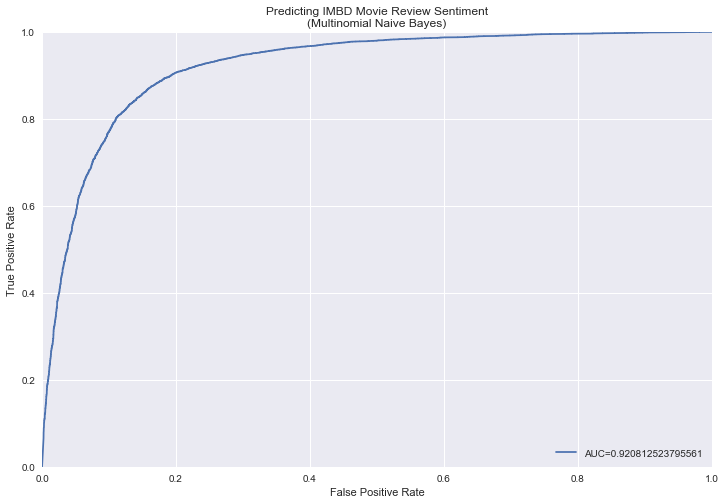

In [26]:
# Plot an ROC Curve
fpr, tpr, _ = roc_curve(y_test, pred_proba)
auc = roc_auc_score(y_test, pred_proba)
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label='AUC={}'.format(auc))
plt.legend(loc=4)
plt.title('Predicting IMBD Movie Review Sentiment\n(Multinomial Naive Bayes)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.margins(0,0)
plt.show()

#### Logistic Regression Classifier:

In [27]:
%%time
# Try logistic regression
lr = LogisticRegression()
grid_params = {'C': np.logspace(-3,3,7), 'penalty': ['l1', 'l2']}
lr_cv = GridSearchCV(lr, grid_params, cv=10, n_jobs=-1, scoring='accuracy')
lr_cv.fit(X_train_vect, y_train)
print('Best parameters: {}'.format(lr_cv.best_params_))
print('Accuracy: {}'.format(lr_cv.best_score_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best parameters: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.8754925373134328
Wall time: 2min 26s


In [28]:
# Evaluate Accuracy & AUC:
pred = lr_cv.predict(vect.transform(X_test))
pred_proba = lr_cv.predict_proba(vect.transform(X_test))[::,1]
print('Accuarcy: {}'.format(accuracy_score(y_test, pred)))
print('Area Under Curve: {}'.format(roc_auc_score(y_test, pred_proba)))

Accuarcy: 0.8750909090909091
Area Under Curve: 0.9443912515701416


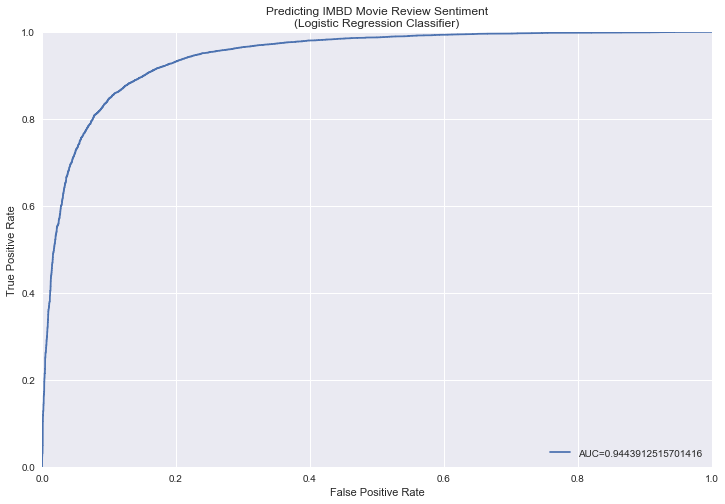

In [29]:
# Plot an ROC Curve
fpr, tpr, _ = roc_curve(y_test, pred_proba)
auc = roc_auc_score(y_test, pred_proba)
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label='AUC={}'.format(auc))
plt.legend(loc=4)
plt.title('Predicting IMBD Movie Review Sentiment\n(Logistic Regression Classifier)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.margins(0,0)
plt.show()

#### KNN Classifier:
- Extremely slow & computationally expensive.

In [ ]:
# X = df['train'].tolist()
# X_vect = TfidfVectorizer().fit_transform(X)

In [ ]:
# # Data fits to the model differently; redo train/test split
# X_train, X_test, y_train, y_test = train_test_split(X_vect, df['coded_sent'], test_size=0.33)

In [ ]:
# %%time

# # Try a general, untuned, model:
# model = KNeighborsClassifier(n_neighbors=5)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# y_pred_proba = model.predict_proba(X_test)[::,1]
# print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
# print('AUC Score: {}'.format(roc_auc_score(y_test, y_pred_proba)))

In [ ]:
# # We can do better:
# params = {'n_neighbors': [10, 20, 30, 40, 50], 'p': [1,2,3], 'leaf_size': [10,30,50]}
# knn = KNeighborsClassifier()
# model = GridSearchCV(knn, params, cv=10, n_jobs=-1, scoring='accuracy')

In [ ]:
# %%time
# model.fit(X_train, y_train)